# 1. Introduction

This notebook explores various stock trading strategies by implementing and backtesting multiple methods, including moving averages, trend following, Relative Strength Index (RSI), standard deviation-based strategies, and a simple buy-and-hold strategy. These strategies are tested on historical stock data to assess their performance in terms of cumulative profits and the Sharpe ratio.

The notebook includes:

Backtesting these strategies on historical data.
Comparing cumulative profits and Sharpe ratios for each method.
Simulating performance on unseen stock data to evaluate how each strategy could perform in real-world trading scenarios.
While machine learning models have gained popularity in the investing space, this notebook focuses on manually coded trading strategies. These strategies are particularly useful for retail traders who may not have access to high-frequency trading platforms. Additionally, while machine learning models can be highly tailored to training data, manual trading strategies rely on simpler logic that could potentially offer more stable results across different datasets.

The results of the strategies presented in this notebook demonstrate that their performance is often more dependent on the volatility and behavior of the stock itself rather than on any one method being universally superior. The findings suggest that while some strategies may outperform others in certain conditions, there is no single "best" strategy for all market scenarios.

# 2. Import Libraries and Setup

In [2]:
# Data manipulation and analysis
import pandas as pd  # For working with dataframes

# Fetching financial data from sources
import pandas_datareader.data as web  # Alternative to Yahoo Finance for stock data
import yfinance as yf  # Main library to pull stock data from Yahoo Finance

# Date handling
import datetime  # For date manipulation and time-series analysis

# Visualization
import matplotlib.pyplot as plt  # For creating visualizations (charts, graphs)

# Numerical operations and feature engineering
import numpy as np  # For working with arrays, numerical operations, and feature engineering

# 3. Data Importing and Structuring

In [3]:
# Uncomment the below when using alternative API with API key
# api_key = "QZHH9RQ09M6928EO" # for datareader from 'av-daily'
# df = web.DataReader('TSLA', 'av-daily', start_train, end_train, api_key=api_key)

In [4]:
start_train = datetime.datetime(2012, 1, 1)
end_train = datetime.datetime(2019, 1, 1)

In [5]:
start_test = datetime.datetime(2019, 1, 1)
end_test = datetime.datetime(2020, 1, 1)

In [6]:
df1 = yf.download('TSLA', start_train, end_train)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [7]:
df1 = df1.rename(columns={'Close': 'close'})

In [8]:
df1

Price,close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2012-01-03,1.872000,1.966667,1.843333,1.929333,13921500
2012-01-04,1.847333,1.911333,1.833333,1.880667,9451500
2012-01-05,1.808000,1.862000,1.790000,1.850667,15082500
2012-01-06,1.794000,1.852667,1.760667,1.813333,14794500
2012-01-09,1.816667,1.832667,1.741333,1.800000,13455000
...,...,...,...,...,...
2018-12-24,19.692667,20.966667,19.680000,20.900000,83398500
2018-12-26,21.739332,21.798000,19.606001,20.000000,122446500


In [9]:
# df = web.DataReader('TSLA', 'av-daily', start_train, end_train, api_key=api_key)

In [10]:
# df.head()

In [11]:
df1.index = pd.to_datetime(df1.index)
print(df1.index)

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
               '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               '2012-01-13', '2012-01-17',
               ...
               '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20',
               '2018-12-21', '2018-12-24', '2018-12-26', '2018-12-27',
               '2018-12-28', '2018-12-31'],
              dtype='datetime64[ns]', name='Date', length=1760, freq=None)


In [12]:
# gets one day signal and log change (won't use log change this strategy)
df1['one_day_signal'] = np.sign(df1['close'].diff())

In [13]:
df1.head()

Price,close,High,Low,Open,Volume,one_day_signal
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,
Date,,,,,,
2012-01-03,1.872000,1.966667,1.843333,1.929333,13921500,NaN
2012-01-04,1.847333,1.911333,1.833333,1.880667,9451500,-1.0
2012-01-05,1.808000,1.862000,1.790000,1.850667,15082500,-1.0
2012-01-06,1.794000,1.852667,1.760667,1.813333,14794500,-1.0
2012-01-09,1.816667,1.832667,1.741333,1.800000,13455000,1.0


In [14]:
df1 = df1.dropna()

In [15]:
df_tsla = df1.copy()

In [16]:
df_spy = yf.download('SPY', start_train, end_train)
df_spy = df_spy.rename(columns={'Close': 'close'})
df_spy.index = pd.to_datetime(df_spy.index)
df_spy['one_day_signal'] = np.sign(df_spy['close'].diff())
df_spy = df_spy.dropna()

[*********************100%***********************]  1 of 1 completed


In [17]:
df_spy

Price,close,High,Low,Open,Volume,one_day_signal
Ticker,SPY,SPY,SPY,SPY,SPY,
Date,,,,,,
2012-01-04,100.910904,100.997828,100.128589,100.515795,127186500,1.0
2012-01-05,101.179573,101.329717,99.907327,100.365655,173895000,1.0
2012-01-06,100.918785,101.321798,100.586895,101.305990,148050000,-1.0
2012-01-09,101.163765,101.290191,100.681731,101.147957,99530200,1.0
2012-01-10,102.040924,102.451829,101.898678,102.246377,115282000,1.0
...,...,...,...,...,...,...
2018-12-24,213.224762,219.139079,213.161077,217.501265,147311600,-1.0
2018-12-26,223.997894,223.997894,212.697003,214.707876,218485400,1.0


### At this point in the code, df_spy and df_tsla are the baseline dataframes. Make copies of them and then adjust the copies, because all future strategies rely on these being the way they are at this point in the code.

# Strategy 1: Buy and Hold at beginning, nothing else

In [18]:
df_tsla_bh = df_tsla.copy()

In [19]:
df_tsla_bh['position'] = 1

In [20]:
df_tsla_bh['Close'] = df_tsla_bh['close']

In [21]:
df_tsla_bh = df_tsla_bh.drop('close', axis=1)

/var/folders/66/fy9yv6yn0d3b_wfpvg6jjqv40000gn/T/ipykernel_3816/2037356992.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_tsla_bh = df_tsla_bh.drop('close', axis=1)


In [22]:
df_tsla_bh.rename(columns={'Close': 'close'}, inplace=True)

In [23]:
df_tsla_bh['returns'] = df_tsla_bh['close'].pct_change()

In [24]:
df_tsla_bh['strategy_return'] = df_tsla_bh['position'] * df_tsla_bh['returns']

In [25]:
df_tsla_bh = df_tsla_bh.dropna().copy()

In [26]:
df_tsla_bh['cumulative_earnings'] = (1+df_tsla_bh['strategy_return']).cumprod()

In [27]:
df_tsla_bh

Price,High,Low,Open,Volume,one_day_signal,position,close,returns,strategy_return,cumulative_earnings
Ticker,TSLA,TSLA,TSLA,TSLA,,,,,,
Date,,,,,,,,,,
2012-01-05,1.862000,1.790000,1.850667,15082500,-1.0,1,1.808000,-0.021292,-0.021292,0.978708
2012-01-06,1.852667,1.760667,1.813333,14794500,-1.0,1,1.794000,-0.007743,-0.007743,0.971130
2012-01-09,1.832667,1.741333,1.800000,13455000,1.0,1,1.816667,0.012635,0.012635,0.983400
2012-01-10,1.850667,1.816667,1.829333,10077000,1.0,1,1.841333,0.013578,0.013578,0.996752
2012-01-11,1.892000,1.820000,1.841333,10084500,1.0,1,1.882000,0.022086,0.022086,1.018766
...,...,...,...,...,...,...,...,...,...,...
2018-12-24,20.966667,19.680000,20.900000,83398500,-1.0,1,19.692667,-0.076242,-0.076242,10.660053
2018-12-26,21.798000,19.606001,20.000000,122446500,1.0,1,21.739332,0.103930,0.103930,11.767956


# TSLA BUY AND HOLD

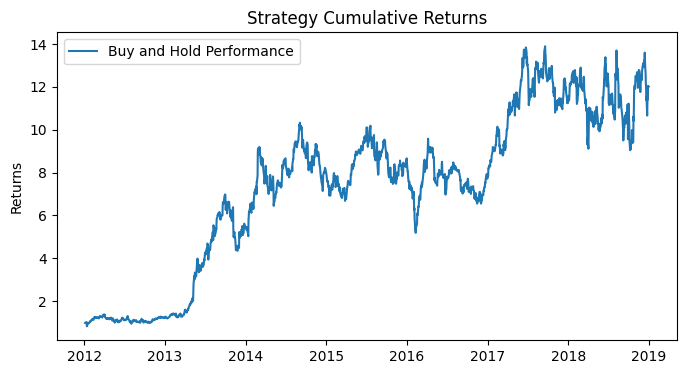

In [28]:
plt.figure(figsize=(8, 4))
plt.plot(df_tsla_bh['cumulative_earnings'], label = 'Buy and Hold Performance')
plt.title('Strategy Cumulative Returns')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [29]:
df_spy_bh = df_spy.copy()

df_spy_bh['Close'] = df_spy_bh['close']
df_spy_bh = df_spy_bh.drop('close', axis=1)
df_spy_bh.rename(columns={'Close': 'close'}, inplace=True)

df_spy_bh['position'] = 1

df_spy_bh['returns'] = df_spy_bh['close'].pct_change()
df_spy_bh = df_spy_bh.dropna().copy()
df_spy_bh['strategy_return'] = df_spy_bh['position'] * df_spy_bh['returns']
df_spy_bh['cumulative_earnings'] = (1+df_spy_bh['strategy_return']).cumprod()

/var/folders/66/fy9yv6yn0d3b_wfpvg6jjqv40000gn/T/ipykernel_3816/621511630.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_spy_bh = df_spy_bh.drop('close', axis=1)


In [30]:
df_spy_bh

Price,High,Low,Open,Volume,one_day_signal,close,position,returns,strategy_return,cumulative_earnings
Ticker,SPY,SPY,SPY,SPY,,,,,,
Date,,,,,,,,,,
2012-01-05,101.329717,99.907327,100.365655,173895000,1.0,101.179573,1,0.002662,0.002662,1.002662
2012-01-06,101.321798,100.586895,101.305990,148050000,-1.0,100.918785,1,-0.002577,-0.002577,1.000078
2012-01-09,101.290191,100.681731,101.147957,99530200,1.0,101.163765,1,0.002427,0.002427,1.002506
2012-01-10,102.451829,101.898678,102.246377,115282000,1.0,102.040924,1,0.008671,0.008671,1.011198
2012-01-11,102.230565,101.558887,101.724826,111540700,1.0,102.096230,1,0.000542,0.000542,1.011746
...,...,...,...,...,...,...,...,...,...,...
2018-12-24,219.139079,213.161077,217.501265,147311600,-1.0,213.224762,1,-0.026423,-0.026423,2.113000
2018-12-26,223.997894,212.697003,214.707876,218485400,1.0,223.997894,1,0.050525,0.050525,2.219759


# SPY BUY AND HOLD

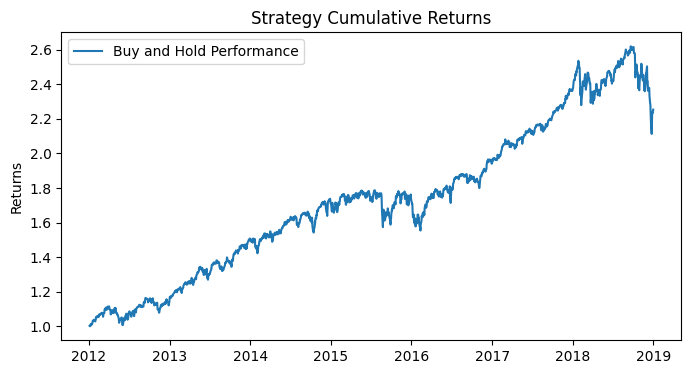

In [31]:
plt.figure(figsize=(8, 4))
plt.plot(df_spy_bh['cumulative_earnings'], label = 'Buy and Hold Performance')
plt.title('Strategy Cumulative Returns')
plt.ylabel('Returns')
plt.legend()
plt.show()

# Strategy 2: Buy if price went up yesterday, Sell if price went down yesterday

In [32]:
df_tsla_ystd = df_tsla.copy()

In [33]:
df_tsla_ystd = df_tsla_ystd.dropna()
df_tsla_ystd.head()

Price,close,High,Low,Open,Volume,one_day_signal
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,
Date,,,,,,
2012-01-04,1.847333,1.911333,1.833333,1.880667,9451500,-1.0
2012-01-05,1.808000,1.862000,1.790000,1.850667,15082500,-1.0
2012-01-06,1.794000,1.852667,1.760667,1.813333,14794500,-1.0
2012-01-09,1.816667,1.832667,1.741333,1.800000,13455000,1.0
2012-01-10,1.841333,1.850667,1.816667,1.829333,10077000,1.0


In [34]:
# filters for columns we need for this strat
df_tsla_ystd = df_tsla_ystd[['close', 'one_day_signal']]

In [35]:
df_tsla_ystd['returns'] = df_tsla_ystd['close'].pct_change()
df_tsla_ystd = df_tsla_ystd.dropna()

In [36]:
df_tsla_ystd.head()

Price,close,one_day_signal,returns
Ticker,TSLA,,
Date,,,
2012-01-05,1.808000,-1.0,-0.021292
2012-01-06,1.794000,-1.0,-0.007743
2012-01-09,1.816667,1.0,0.012635
2012-01-10,1.841333,1.0,0.013578
2012-01-11,1.882000,1.0,0.022086


In [37]:
df_tsla_ystd['position_choice'] = df_tsla_ystd['one_day_signal'].shift(1)

In [38]:
df_tsla_ystd.head()

Price,close,one_day_signal,returns,position_choice
Ticker,TSLA,,,
Date,,,,
2012-01-05,1.808000,-1.0,-0.021292,NaN
2012-01-06,1.794000,-1.0,-0.007743,-1.0
2012-01-09,1.816667,1.0,0.012635,-1.0
2012-01-10,1.841333,1.0,0.013578,1.0
2012-01-11,1.882000,1.0,0.022086,1.0


In [39]:
df_tsla_ystd['strategy_return'] = df_tsla_ystd['position_choice']*df_tsla_ystd['returns']

In [40]:
df_tsla_ystd['cumulative_earnings'] = (1+df_tsla_ystd['strategy_return']).cumprod()

In [41]:
df_tsla_ystd['cumulative_earnings']

Date
2012-01-05         NaN
2012-01-06    1.007743
2012-01-09    0.995011
2012-01-10    1.008521
2012-01-11    1.030794
                ...   
2018-12-24    0.474647
2018-12-26    0.425317
2018-12-27    0.412326
2018-12-28    0.389188
2018-12-31    0.387941
Name: cumulative_earnings, Length: 1758, dtype: float64

# TSLA One Day Signal

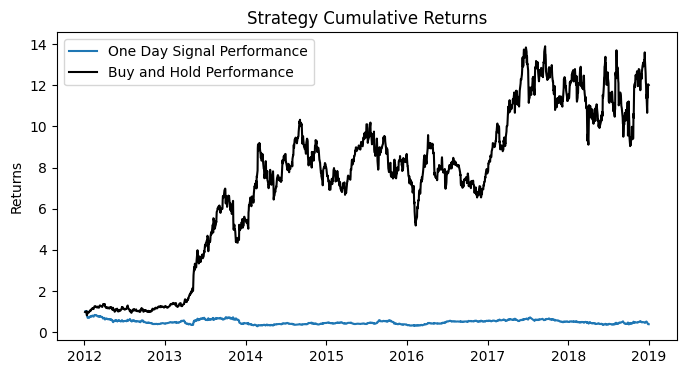

In [42]:
plt.figure(figsize=(8, 4))
plt.plot(df_tsla_ystd['cumulative_earnings'], label = 'One Day Signal Performance')
plt.plot(df_tsla_bh['cumulative_earnings'], label = 'Buy and Hold Performance', color='black')
plt.title('Strategy Cumulative Returns')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [43]:
df_tsla_ystd

Price,close,one_day_signal,returns,position_choice,strategy_return,cumulative_earnings
Ticker,TSLA,,,,,
Date,,,,,,
2012-01-05,1.808000,-1.0,-0.021292,NaN,NaN,NaN
2012-01-06,1.794000,-1.0,-0.007743,-1.0,0.007743,1.007743
2012-01-09,1.816667,1.0,0.012635,-1.0,-0.012635,0.995011
2012-01-10,1.841333,1.0,0.013578,1.0,0.013578,1.008521
2012-01-11,1.882000,1.0,0.022086,1.0,0.022086,1.030794
...,...,...,...,...,...,...
2018-12-24,19.692667,-1.0,-0.076242,1.0,-0.076242,0.474647
2018-12-26,21.739332,1.0,0.103930,-1.0,-0.103930,0.425317


## It seems as though the strategy did badly, losing just over 3% of its value. Next I will try this strategy on SPY, to see if Tesla's volatility is throwing off this strategy. 

In [44]:
df_spy_ystd = df_spy[['close', 'one_day_signal']].copy()

In [45]:
df_spy_ystd.head()

Price,close,one_day_signal
Ticker,SPY,
Date,,
2012-01-04,100.910904,1.0
2012-01-05,101.179573,1.0
2012-01-06,100.918785,-1.0
2012-01-09,101.163765,1.0
2012-01-10,102.040924,1.0


In [46]:
df_spy_ystd['returns'] = df_spy_ystd['close'].pct_change()

In [47]:
df_spy_ystd

Price,close,one_day_signal,returns
Ticker,SPY,,
Date,,,
2012-01-04,100.910904,1.0,NaN
2012-01-05,101.179573,1.0,0.002662
2012-01-06,100.918785,-1.0,-0.002577
2012-01-09,101.163765,1.0,0.002427
2012-01-10,102.040924,1.0,0.008671
...,...,...,...
2018-12-24,213.224762,-1.0,-0.026423
2018-12-26,223.997894,1.0,0.050525


In [48]:
df_spy_ystd = df_spy_ystd.dropna().copy()

In [49]:
df_spy_ystd['position_choice'] = df_spy_ystd['one_day_signal'].shift(1)

In [50]:
df_spy_ystd

Price,close,one_day_signal,returns,position_choice
Ticker,SPY,,,
Date,,,,
2012-01-05,101.179573,1.0,0.002662,NaN
2012-01-06,100.918785,-1.0,-0.002577,1.0
2012-01-09,101.163765,1.0,0.002427,-1.0
2012-01-10,102.040924,1.0,0.008671,1.0
2012-01-11,102.096230,1.0,0.000542,1.0
...,...,...,...,...
2018-12-24,213.224762,-1.0,-0.026423,-1.0
2018-12-26,223.997894,1.0,0.050525,-1.0


In [51]:
df_spy_ystd = df_spy_ystd.dropna().copy()

In [52]:
df_spy_ystd['strategy_return'] = df_spy_ystd['position_choice']*df_spy_ystd['returns']

In [53]:
df_spy_ystd

Price,close,one_day_signal,returns,position_choice,strategy_return
Ticker,SPY,,,,
Date,,,,,
2012-01-06,100.918785,-1.0,-0.002577,1.0,-0.002577
2012-01-09,101.163765,1.0,0.002427,-1.0,-0.002427
2012-01-10,102.040924,1.0,0.008671,1.0,0.008671
2012-01-11,102.096230,1.0,0.000542,1.0,0.000542
2012-01-12,102.341179,1.0,0.002399,1.0,0.002399
...,...,...,...,...,...
2018-12-24,213.224762,-1.0,-0.026423,-1.0,0.026423
2018-12-26,223.997894,1.0,0.050525,-1.0,-0.050525


In [54]:
df_spy_ystd['cumulative_earnings'] = (1+df_spy_ystd['strategy_return']).cumprod()

In [55]:
df_spy_ystd

Price,close,one_day_signal,returns,position_choice,strategy_return,cumulative_earnings
Ticker,SPY,,,,,
Date,,,,,,
2012-01-06,100.918785,-1.0,-0.002577,1.0,-0.002577,0.997423
2012-01-09,101.163765,1.0,0.002427,-1.0,-0.002427,0.995001
2012-01-10,102.040924,1.0,0.008671,1.0,0.008671,1.003629
2012-01-11,102.096230,1.0,0.000542,1.0,0.000542,1.004173
2012-01-12,102.341179,1.0,0.002399,1.0,0.002399,1.006582
...,...,...,...,...,...,...
2018-12-24,213.224762,-1.0,-0.026423,-1.0,0.026423,1.000866
2018-12-26,223.997894,1.0,0.050525,-1.0,-0.050525,0.950297


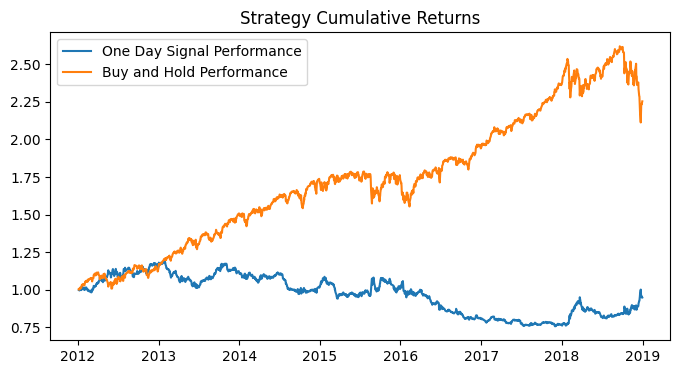

In [56]:
plt.figure(figsize=(8, 4))
plt.plot(df_spy_ystd['cumulative_earnings'], label = 'One Day Signal Performance')
plt.plot(df_spy_bh['cumulative_earnings'], label = 'Buy and Hold Performance')
plt.title('Strategy Cumulative Returns')
plt.legend()
plt.show()

# One Day Signal Performance has proven to be a bad method.

# Strategy 3: Mean Reversion

In [115]:
df_tsla_ma = df_tsla.copy()

In [116]:
df_tsla_ma['Close'] = df_tsla_ma['close']

In [117]:
df_tsla_ma = df_tsla_ma.drop('close', axis=1)

/var/folders/66/fy9yv6yn0d3b_wfpvg6jjqv40000gn/T/ipykernel_3816/4094493994.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_tsla_ma = df_tsla_ma.drop('close', axis=1)


In [118]:
df_tsla_ma.rename(columns={'Close': 'close'}, inplace=True)

In [119]:
df_tsla_ma[df_tsla_ma['close'] == 0]
# close is never zero here
df_tsla_ma[df_tsla_ma['close'].isnull()]
# never null either

Price,High,Low,Open,Volume,one_day_signal,close
Ticker,TSLA,TSLA,TSLA,TSLA,,
Date,,,,,,


In [120]:
df_tsla_ma['50_day_ma'] = df_tsla_ma['close'].rolling(window=50).mean()

In [121]:
df_tsla_ma['50_day_std'] = df_tsla_ma['close'].rolling(window=50).std()

In [122]:
df_tsla_ma = df_tsla_ma.dropna().copy()

In [123]:
threshold = 1.5
stop_loss = 0.02

In [124]:
df_tsla_ma

Price,High,Low,Open,Volume,one_day_signal,close,50_day_ma,50_day_std
Ticker,TSLA,TSLA,TSLA,TSLA,,,,
Date,,,,,,,,
2012-03-15,2.365333,2.318667,2.352000,8574000,-1.0,2.333333,2.074147,0.218423
2012-03-16,2.392667,2.322000,2.326667,10939500,1.0,2.354667,2.084293,0.219453
2012-03-19,2.354667,2.302667,2.350667,15234000,-1.0,2.332000,2.094773,0.218499
2012-03-20,2.346667,2.304667,2.332000,8505000,-1.0,2.330667,2.105507,0.216596
2012-03-21,2.353333,2.306667,2.329333,9108000,1.0,2.343333,2.116040,0.215064
...,...,...,...,...,...,...,...,...
2018-12-24,20.966667,19.680000,20.900000,83398500,-1.0,19.692667,22.060880,2.168596
2018-12-26,21.798000,19.606001,20.000000,122446500,1.0,21.739332,22.150627,2.055421


In [125]:
df_tsla_ma['buy_threshold'] = df_tsla_ma['50_day_ma'] - (df_tsla_ma['50_day_std']*threshold)

In [126]:
df_tsla_ma['position'] = 0

In [127]:
df_tsla_ma.loc[(df_tsla_ma['close']) < df_tsla_ma['buy_threshold'], 'position'] = 1

In [128]:
df_tsla_ma.loc[
        (df_tsla_ma['close'].shift(1) > df_tsla_ma['50_day_ma'].shift(1)) &
        (df_tsla_ma['close'] < df_tsla_ma['close'].shift(1)*(1-stop_loss)), 'position'] = 0 #went down 2%

# strategy will buy and hold when close goes below buy threshold and until 
# close goes above moving average and then goes down by 2%. 

In [129]:
df_tsla_ma[df_tsla_ma['close'] == 0]
# close is never zero here

Price,High,Low,Open,Volume,one_day_signal,close,50_day_ma,50_day_std,buy_threshold,position
Ticker,TSLA,TSLA,TSLA,TSLA,,,,,,
Date,,,,,,,,,,


In [130]:
df_tsla_ma['position'] = df_tsla_ma['position'].replace(0, np.nan).ffill().fillna(0)

In [131]:
df_tsla_ma['daily_return'] = df_tsla_ma['close'].pct_change()

In [132]:
df_tsla_ma['strategy_return'] = df_tsla_ma['daily_return']*df_tsla_ma['position']

In [133]:
df_tsla_ma['cumulative_strategy'] = (1 + df_tsla_ma['strategy_return']).cumprod()

In [134]:
df_tsla_ma

Price,High,Low,Open,Volume,one_day_signal,close,50_day_ma,50_day_std,buy_threshold,position,daily_return,strategy_return,cumulative_strategy
Ticker,TSLA,TSLA,TSLA,TSLA,,,,,,,,,
Date,,,,,,,,,,,,,
2012-03-15,2.365333,2.318667,2.352000,8574000,-1.0,2.333333,2.074147,0.218423,1.746512,0.0,NaN,NaN,NaN
2012-03-16,2.392667,2.322000,2.326667,10939500,1.0,2.354667,2.084293,0.219453,1.755113,0.0,0.009143,0.000000,1.000000
2012-03-19,2.354667,2.302667,2.350667,15234000,-1.0,2.332000,2.094773,0.218499,1.767024,0.0,-0.009626,-0.000000,1.000000
2012-03-20,2.346667,2.304667,2.332000,8505000,-1.0,2.330667,2.105507,0.216596,1.780612,0.0,-0.000572,-0.000000,1.000000
2012-03-21,2.353333,2.306667,2.329333,9108000,1.0,2.343333,2.116040,0.215064,1.793445,0.0,0.005434,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,20.966667,19.680000,20.900000,83398500,-1.0,19.692667,22.060880,2.168596,18.807986,1.0,-0.076242,-0.076242,9.248280
2018-12-26,21.798000,19.606001,20.000000,122446500,1.0,21.739332,22.150627,2.055421,19.067495,1.0,0.103930,0.103930,10.209456


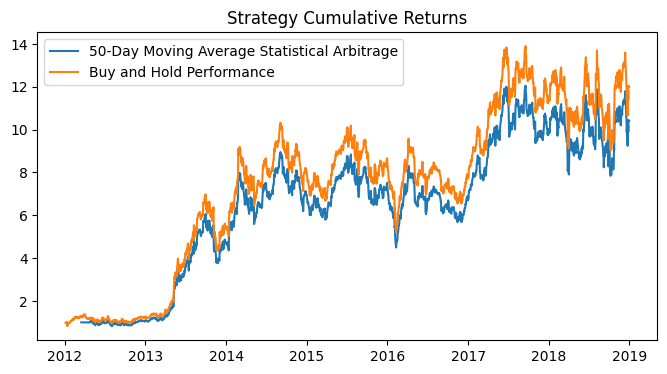

In [135]:
plt.figure(figsize=(8, 4))
plt.plot(df_tsla_ma['cumulative_strategy'], label = '50-Day Moving Average Statistical Arbitrage')
plt.plot(df_tsla_bh['cumulative_earnings'], label = 'Buy and Hold Performance')
plt.title('Strategy Cumulative Returns')
plt.legend()
plt.show()

# Now to use SPY:

In [77]:
df_spy_ma = df_spy.copy()

In [78]:
df_spy_ma['Close'] = df_spy_ma['close']
df_spy_ma = df_spy_ma.drop('close', axis=1)
df_spy_ma.rename(columns={'Close': 'close'}, inplace=True)
df_spy_ma['50_day_ma'] = df_spy_ma['close'].rolling(window=50).mean()
df_spy_ma['50_day_std'] = df_spy_ma['close'].rolling(window=50).std()
df_spy_ma = df_spy_ma.dropna().copy()

/var/folders/66/fy9yv6yn0d3b_wfpvg6jjqv40000gn/T/ipykernel_3816/4113317447.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_spy_ma = df_spy_ma.drop('close', axis=1)


In [79]:
threshold = 1.5
stop_loss = 0.02

In [80]:
df_spy_ma['buy_threshold'] = df_spy_ma['50_day_ma'] - (df_spy_ma['50_day_std']*threshold)

In [81]:
df_spy_ma['position'] = 0

In [82]:
df_spy_ma.loc[(df_spy_ma['close']) < df_spy_ma['buy_threshold'], 'position'] = 1

In [83]:
df_spy_ma.loc[
        (df_spy_ma['close'].shift(1) > df_spy_ma['50_day_ma'].shift(1)) &
        (df_spy_ma['close'] < df_spy_ma['close'].shift(1)*(1-stop_loss)), 'position'] = 0 #went down 2%

# strategy will buy and hold when close goes below buy threshold and until 
# close goes above moving average and then goes down by 2%. 

In [84]:
df_spy_ma[df_spy_ma['close'] == 0]
# close is never zero here

Price,High,Low,Open,Volume,one_day_signal,close,50_day_ma,50_day_std,buy_threshold,position
Ticker,SPY,SPY,SPY,SPY,,,,,,
Date,,,,,,,,,,


In [85]:
df_spy_ma['position'] = df_spy_ma['position'].replace(0, np.nan).ffill().fillna(0)

In [86]:
df_spy_ma['daily_return'] = df_spy_ma['close'].pct_change()

In [87]:
df_spy_ma['strategy_return'] = df_spy_ma['daily_return']*df_spy_ma['position']

In [88]:
df_spy_ma['cumulative_strategy'] = (1 + df_spy_ma['strategy_return']).cumprod()

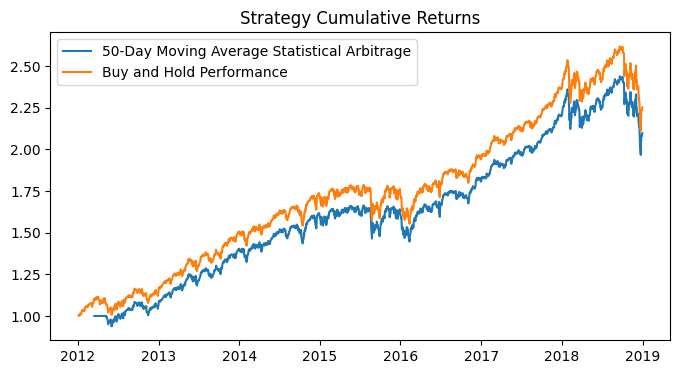

In [89]:
plt.figure(figsize=(8, 4))
plt.plot(df_spy_ma['cumulative_strategy'], label = '50-Day Moving Average Statistical Arbitrage')
plt.plot(df_spy_bh['cumulative_earnings'], label = 'Buy and Hold Performance')
plt.title('Strategy Cumulative Returns')
plt.legend()
plt.show()

## It seems the sell trigger does not happen often.
## I am going to try a different strategy; this time, if the stock goes below 1.5 standard deviations below the moving average, we buy and hold until it goes above 1.5 standard deviations above the moving average, then we sell. 

In [90]:
df_spy_ma = df_spy.copy()

In [91]:
df_spy_ma['Close'] = df_spy_ma['close']
df_spy_ma = df_spy_ma.drop('close', axis=1)
df_spy_ma.rename(columns={'Close': 'close'}, inplace=True)
df_spy_ma['50_day_ma'] = df_spy_ma['close'].rolling(window=50).mean()
df_spy_ma['50_day_std'] = df_spy_ma['close'].rolling(window=50).std()
df_spy_ma = df_spy_ma.dropna().copy()

/var/folders/66/fy9yv6yn0d3b_wfpvg6jjqv40000gn/T/ipykernel_3816/4113317447.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_spy_ma = df_spy_ma.drop('close', axis=1)


In [92]:
threshold = 1.5

In [93]:
df_spy_ma['buy_threshold'] = df_spy_ma['50_day_ma'] - (df_spy_ma['50_day_std']*threshold)
df_spy_ma['sell_threshold'] = df_spy_ma['50_day_ma'] + (df_spy_ma['50_day_std']*threshold)

In [94]:
df_spy_ma['position'] = np.nan

In [95]:
df_spy_ma.loc[(df_spy_ma['close']) < df_spy_ma['buy_threshold'], 'position'] = 1
df_spy_ma.loc[(df_spy_ma['close']) > df_spy_ma['buy_threshold'], 'position'] = 0

In [96]:
df_spy_ma['position'] = df_spy_ma['position'].ffill().fillna(0)

In [97]:
df_spy_ma

Price,High,Low,Open,Volume,one_day_signal,close,50_day_ma,50_day_std,buy_threshold,sell_threshold,position
Ticker,SPY,SPY,SPY,SPY,,,,,,,
Date,,,,,,,,,,,
2012-03-15,111.246935,110.440909,110.725388,165118500,1.0,111.199524,105.857819,2.745618,101.739391,109.976246,0.0
2012-03-16,111.496350,111.115386,111.401112,152893500,1.0,111.353493,106.066671,2.758779,101.928503,110.204838,0.0
2012-03-19,112.131309,111.202703,111.282076,125291100,1.0,111.790031,106.278880,2.783162,102.104136,110.453623,0.0
2012-03-20,111.599547,110.829675,111.155087,121729700,-1.0,111.464622,106.489796,2.768226,102.337458,110.642135,0.0
2012-03-21,111.631291,111.051907,111.528121,122388400,-1.0,111.282082,106.692163,2.740633,102.581213,110.803112,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,219.139079,213.161077,217.501265,147311600,-1.0,213.224762,242.815360,8.677112,229.799691,255.831028,1.0
2018-12-26,223.997894,212.697003,214.707876,218485400,1.0,223.997894,242.302763,9.016846,228.777493,255.828032,1.0


In [98]:
df_spy_ma['daily_return'] = df_spy_ma['close'].pct_change()

In [99]:
df_spy_ma['strategy_return'] = df_spy_ma['daily_return']*df_spy_ma['position']

In [100]:
df_spy_ma['cumulative_strategy'] = (1 + df_spy_ma['strategy_return']).cumprod()

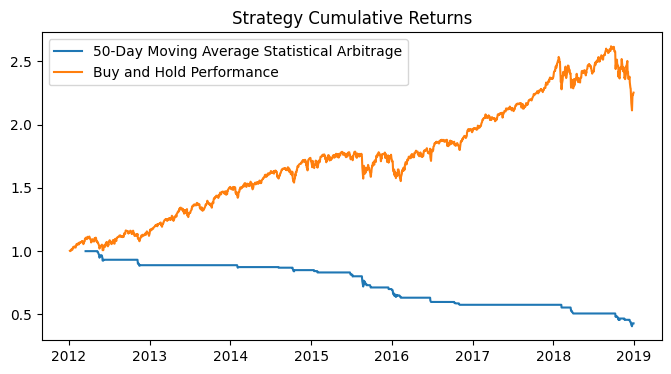

In [101]:
plt.figure(figsize=(8, 4))
plt.plot(df_spy_ma['cumulative_strategy'], label = '50-Day Moving Average Statistical Arbitrage')
plt.plot(df_spy_bh['cumulative_earnings'], label = 'Buy and Hold Performance')
plt.title('Strategy Cumulative Returns')
plt.legend()
plt.show()

/var/folders/66/fy9yv6yn0d3b_wfpvg6jjqv40000gn/T/ipykernel_3816/484593005.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_tsla_ma = df_tsla_ma.drop('close', axis=1)


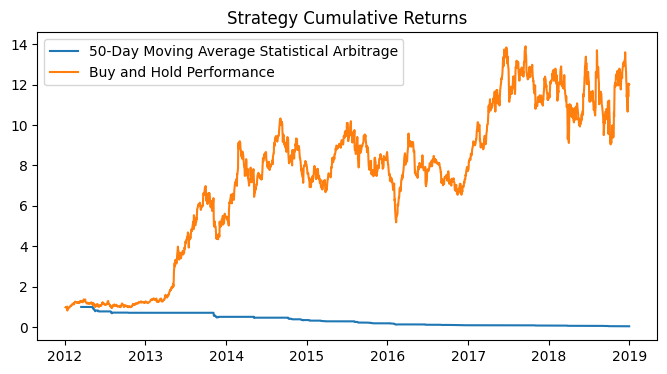

In [102]:
df_tsla_ma = df_tsla.copy()
df_tsla_ma['Close'] = df_tsla_ma['close']
df_tsla_ma = df_tsla_ma.drop('close', axis=1)
df_tsla_ma.rename(columns={'Close': 'close'}, inplace=True)
df_tsla_ma['50_day_ma'] = df_tsla_ma['close'].rolling(window=50).mean()
df_tsla_ma['50_day_std'] = df_tsla_ma['close'].rolling(window=50).std()
df_tsla_ma = df_tsla_ma.dropna().copy()
threshold = 1.5
df_tsla_ma['buy_threshold'] = df_tsla_ma['50_day_ma'] - (df_tsla_ma['50_day_std']*threshold)
df_tsla_ma['sell_threshold'] = df_tsla_ma['50_day_ma'] + (df_tsla_ma['50_day_std']*threshold)
df_tsla_ma['position'] = np.nan
df_tsla_ma.loc[(df_tsla_ma['close']) < df_tsla_ma['buy_threshold'], 'position'] = 1
df_tsla_ma.loc[(df_tsla_ma['close']) > df_tsla_ma['buy_threshold'], 'position'] = 0
df_tsla_ma['position'] = df_tsla_ma['position'].ffill().fillna(0)
df_tsla_ma['daily_return'] = df_tsla_ma['close'].pct_change()
df_tsla_ma['strategy_return'] = df_tsla_ma['daily_return']*df_tsla_ma['position']
df_tsla_ma['cumulative_strategy'] = (1 + df_tsla_ma['strategy_return']).cumprod()

plt.figure(figsize=(8, 4))
plt.plot(df_tsla_ma['cumulative_strategy'], label = '50-Day Moving Average Statistical Arbitrage')
plt.plot(df_tsla_bh['cumulative_earnings'], label = 'Buy and Hold Performance')
plt.title('Strategy Cumulative Returns')
plt.legend()
plt.show()

# Strategy 4: Trend Following

### I believe this strategy will perform best on TSLA and SPY since they follow an upward trend, rather than being highly volatile and crossing above and below a mean repeatedly. 

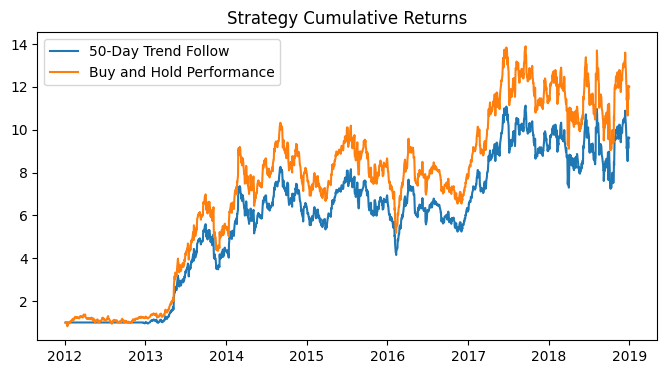

In [103]:
df_tsla_tf = df_tsla.copy()

df_tsla_tf['50_day_ma'] = df_tsla_tf['close'].rolling(window=50).mean()  
df_tsla_tf['200_day_ma'] = df_tsla_tf['close'].rolling(window=200).mean() 

df_tsla_tf.loc[df_tsla_tf['50_day_ma'] > df_tsla_tf['200_day_ma'], 'position'] = 1

df_tsla_tf.loc[df_tsla_tf['50_day_ma'] < df_tsla_tf['200_day_ma'], 'position'] = 0

df_tsla_tf['position'] = df_tsla_tf['position'].replace(0, np.nan).ffill().fillna(0)

df_tsla_tf['daily_return'] = df_tsla_tf['close'].pct_change()

df_tsla_tf['strategy_return'] = df_tsla_tf['daily_return'] * df_tsla_tf['position']

df_tsla_tf['cumulative_strategy'] = (1 + df_tsla_tf['strategy_return']).cumprod()

plt.figure(figsize=(8, 4))
plt.plot(df_tsla_tf['cumulative_strategy'], label = '50-Day Trend Follow')
plt.plot(df_tsla_bh['cumulative_earnings'], label = 'Buy and Hold Performance')
plt.title('Strategy Cumulative Returns')
plt.legend()
plt.show()

In [142]:
df_tsla_tf

Price,close,High,Low,Open,Volume,one_day_signal,50_day_ma,200_day_ma,position,daily_return,strategy_return,cumulative_strategy
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,,,,,,,
Date,,,,,,,,,,,,
2012-01-04,1.847333,1.911333,1.833333,1.880667,9451500,-1.0,NaN,NaN,0.0,NaN,NaN,NaN
2012-01-05,1.808000,1.862000,1.790000,1.850667,15082500,-1.0,NaN,NaN,0.0,-0.021292,-0.000000,1.000000
2012-01-06,1.794000,1.852667,1.760667,1.813333,14794500,-1.0,NaN,NaN,0.0,-0.007743,-0.000000,1.000000
2012-01-09,1.816667,1.832667,1.741333,1.800000,13455000,1.0,NaN,NaN,0.0,0.012635,0.000000,1.000000
2012-01-10,1.841333,1.850667,1.816667,1.829333,10077000,1.0,NaN,NaN,0.0,0.013578,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,19.692667,20.966667,19.680000,20.900000,83398500,-1.0,22.060880,20.843237,1.0,-0.076242,-0.076242,8.534818
2018-12-26,21.739332,21.798000,19.606001,20.000000,122446500,1.0,22.150627,20.836763,1.0,0.103930,0.103930,9.421844


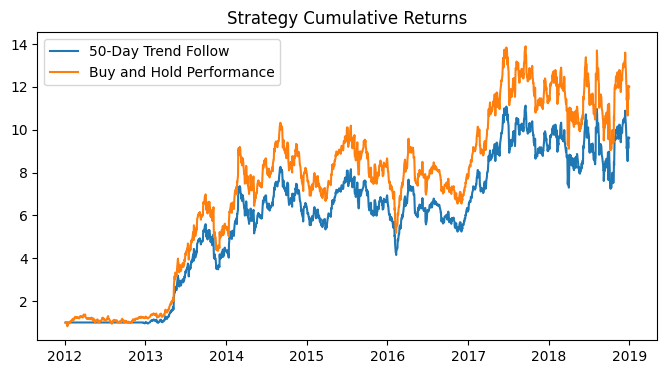

In [104]:
df_spy_tf = df_spy.copy()

df_spy_tf['50_day_ma'] = df_spy_tf['close'].rolling(window=50).mean()  
df_spy_tf['200_day_ma'] = df_spy_tf['close'].rolling(window=200).mean() 

df_spy_tf.loc[df_spy_tf['50_day_ma'] > df_spy_tf['200_day_ma'], 'position'] = 1

df_spy_tf.loc[df_spy_tf['50_day_ma'] < df_spy_tf['200_day_ma'], 'position'] = 0

df_spy_tf['position'] = df_spy_tf['position'].replace(0, np.nan).ffill().fillna(0)

df_spy_tf['daily_return'] = df_spy_tf['close'].pct_change()

df_spy_tf['strategy_return'] = df_spy_tf['daily_return'] * df_spy_tf['position']

df_spy_tf['cumulative_strategy'] = (1 + df_spy_tf['strategy_return']).cumprod()

plt.figure(figsize=(8, 4))
plt.plot(df_tsla_tf['cumulative_strategy'], label = '50-Day Trend Follow')
plt.plot(df_tsla_bh['cumulative_earnings'], label = 'Buy and Hold Performance')
plt.title('Strategy Cumulative Returns')
plt.legend()
plt.show()

# Overall results for Tesla so far:

In [138]:
final_profit_tf = df_tsla_tf['cumulative_strategy'].iloc[-1]
final_profit_bh = df_tsla_bh['cumulative_earnings'].iloc[-1]
final_profit_ma = df_tsla_ma['cumulative_strategy'].iloc[-1]
final_profit_ystd = df_tsla_ystd['cumulative_earnings'].iloc[-1]

In [139]:
print(final_profit_tf)
print(final_profit_bh)
print(final_profit_ma)
print(final_profit_ystd)

9.61571934360963
12.010107022517014
10.419538084462388
0.3879405529595242


In [163]:
def sharpe(df):
    #df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    #mean_log_return = df['log_return'].mean()
    #std_log_return = df['log_return'].std()
    mean_return = df['strategy_return'].mean()
    std_return = df['strategy_return'].std()
    annualized_mean = mean_return * 252
    annualized_std = std_return * np.sqrt(252)
    sharpe_ratio = annualized_mean / annualized_std
    return sharpe_ratio

In [141]:
print("Tesla Sharpe Ratios: Buy and Hold: ", sharpe(df_tsla_bh), ", Trend Following: ", sharpe(df_tsla_tf), 
     ", Mean Reversion: ", sharpe(df_tsla_ma), ", Yesterday Price Movement: ", sharpe(df_tsla_ystd))

Tesla Sharpe Ratios: Buy and Hold:  0.9602834617651579 , Trend Following:  0.9338230014475266 , Mean Reversion:  0.9464707973243223 , Yesterday Price Movement:  -0.019741176228277837


In [113]:
average_return = df_tsla_tf['strategy_return'].mean()
standard_deviation = df_tsla_tf['strategy_return'].std()
sharpe = average_return / standard_deviation
print('trend following sharpe is', sharpe)

trend following sharpe is 0.05882531977100154


In [136]:
average_return = df_tsla_ma['strategy_return'].mean()
standard_deviation = df_tsla_ma['strategy_return'].std()
sharpe = average_return / standard_deviation
print('mean reversion sharpe is', sharpe)

mean reversion sharpe is 0.05962205602155176


In [116]:
average_return = df_tsla_bh['strategy_return'].mean()
standard_deviation = df_tsla_bh['strategy_return'].std()
sharpe = average_return / standard_deviation
print('buy and hold sharpe is', sharpe)

buy and hold sharpe is 0.06049217209425738


In [117]:
average_return = df_tsla_ystd['strategy_return'].mean()
standard_deviation = df_tsla_ystd['strategy_return'].std()
sharpe = average_return / standard_deviation
print('yesterday price movement', sharpe)

yesterday price movement -0.0012435772116172195


# Strategy 5: RSI

In [145]:
df_tsla_rsi = df_tsla.copy()
df_tsla_rsi['Close'] = df_tsla_rsi['close']
df_tsla_rsi = df_tsla_rsi.drop(columns=('close'), axis=1)
df_tsla_rsi = df_tsla_rsi.rename(columns=({'Close': 'close'}))
df_tsla_rsi['log_returns'] = np.log(df_tsla_rsi['close'] / df_tsla_rsi['close'].shift(1))
df_tsla_rsi.head()

/var/folders/66/fy9yv6yn0d3b_wfpvg6jjqv40000gn/T/ipykernel_3816/996975977.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_tsla_rsi = df_tsla_rsi.drop(columns=('close'), axis=1)


Price,High,Low,Open,Volume,one_day_signal,close,log_returns
Ticker,TSLA,TSLA,TSLA,TSLA,,,
Date,,,,,,,
2012-01-04,1.911333,1.833333,1.880667,9451500,-1.0,1.847333,NaN
2012-01-05,1.862000,1.790000,1.850667,15082500,-1.0,1.808000,-0.021522
2012-01-06,1.852667,1.760667,1.813333,14794500,-1.0,1.794000,-0.007773
2012-01-09,1.832667,1.741333,1.800000,13455000,1.0,1.816667,0.012556
2012-01-10,1.850667,1.816667,1.829333,10077000,1.0,1.841333,0.013486


In [203]:
# function to get rsi value
def get_rsi(df, window=14):
    price_change = df['close'].diff()
    gain = np.where(price_change > 0, price_change, 0)
    loss = np.where(price_change < 0, -price_change, 0)
    
    rs = pd.Series(gain).ewm(span=14, adjust=False).mean()/pd.Series(loss).ewm(span=14, adjust=False).mean()
    
    rsi = 100 - (100/(1+rs))
    
    rsi = rsi.to_numpy() 
    
    df['RSI'] = rsi
    return rsi

In [147]:
# function to apply the strategy to a dataframe with the rsi column and close prices
def rsi_strategy(df, rsi_buy=30, rsi_sell=70):
    df['position'] = np.nan
    df.loc[df['RSI'] < rsi_buy, 'position'] = 1
    df.loc[df['RSI'] > rsi_sell, 'position'] = 0
    
    df['position'] = df['position'].ffill()
    
    # returns:
    df['daily_return'] = df['close'].pct_change()
    df['strategy_return'] = df['daily_return']*df['position'].shift(1)
    df['cumulative_return'] = (1+df['strategy_return']).cumprod()
    return df

In [148]:
get_rsi(df_tsla_rsi)

Price,High,Low,Open,Volume,one_day_signal,close,log_returns,RSI
Ticker,TSLA,TSLA,TSLA,TSLA,,,,
Date,,,,,,,,
2012-01-04,1.911333,1.833333,1.880667,9451500,-1.0,1.847333,NaN,NaN
2012-01-05,1.862000,1.790000,1.850667,15082500,-1.0,1.808000,-0.021522,0.000000
2012-01-06,1.852667,1.760667,1.813333,14794500,-1.0,1.794000,-0.007773,0.000000
2012-01-09,1.832667,1.741333,1.800000,13455000,1.0,1.816667,0.012556,35.227920
2012-01-10,1.850667,1.816667,1.829333,10077000,1.0,1.841333,0.013486,55.091918
...,...,...,...,...,...,...,...,...
2018-12-24,20.966667,19.680000,20.900000,83398500,-1.0,19.692667,-0.079305,19.536464
2018-12-26,21.798000,19.606001,20.000000,122446500,1.0,21.739332,0.098877,44.401984


In [149]:
rsi_strategy(df_tsla_rsi)

Price,High,Low,Open,Volume,one_day_signal,close,log_returns,RSI,position,daily_return,strategy_return,cumulative_return
Ticker,TSLA,TSLA,TSLA,TSLA,,,,,,,,
Date,,,,,,,,,,,,
2012-01-04,1.911333,1.833333,1.880667,9451500,-1.0,1.847333,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,1.862000,1.790000,1.850667,15082500,-1.0,1.808000,-0.021522,0.000000,1.0,-0.021292,NaN,NaN
2012-01-06,1.852667,1.760667,1.813333,14794500,-1.0,1.794000,-0.007773,0.000000,1.0,-0.007743,-0.007743,0.992257
2012-01-09,1.832667,1.741333,1.800000,13455000,1.0,1.816667,0.012556,35.227920,1.0,0.012635,0.012635,1.004794
2012-01-10,1.850667,1.816667,1.829333,10077000,1.0,1.841333,0.013486,55.091918,1.0,0.013578,0.013578,1.018436
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,20.966667,19.680000,20.900000,83398500,-1.0,19.692667,-0.079305,19.536464,1.0,-0.076242,-0.076242,2.428227
2018-12-26,21.798000,19.606001,20.000000,122446500,1.0,21.739332,0.098877,44.401984,1.0,0.103930,0.103930,2.680593


In [151]:
df_tsla_rsi['position'].sum()

729.0

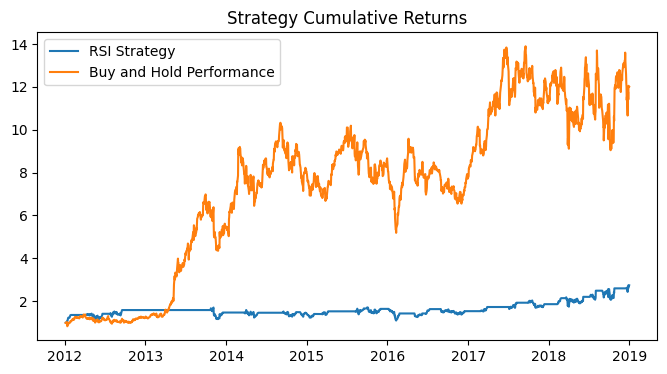

In [152]:
plt.figure(figsize=(8, 4))
plt.plot(df_tsla_rsi['cumulative_return'], label = 'RSI Strategy')
plt.plot(df_tsla_bh['cumulative_earnings'], label = 'Buy and Hold Performance')
plt.title('Strategy Cumulative Returns')
plt.legend()
plt.show()

## doesn't stay in market enough. will try again with different parameters

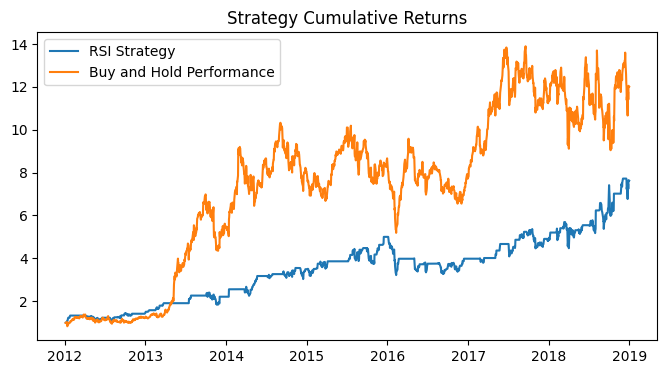

In [153]:
rsi_strategy(df_tsla_rsi, rsi_buy=40, rsi_sell=60)
plt.figure(figsize=(8, 4))
plt.plot(df_tsla_rsi['cumulative_return'], label = 'RSI Strategy')
plt.plot(df_tsla_bh['cumulative_earnings'], label = 'Buy and Hold Performance')
plt.title('Strategy Cumulative Returns')
plt.legend()
plt.show()

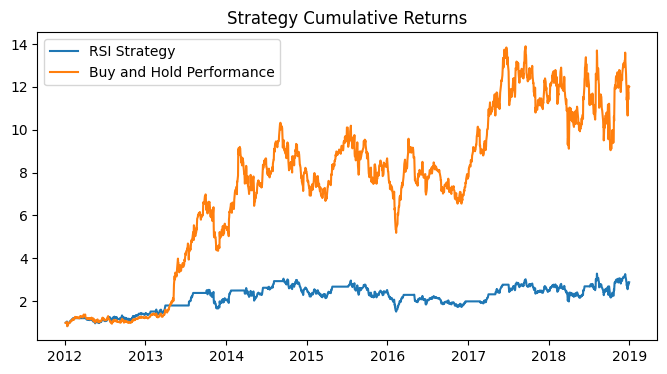

In [154]:
rsi_strategy(df_tsla_rsi, rsi_buy=40, rsi_sell=80)
plt.figure(figsize=(8, 4))
plt.plot(df_tsla_rsi['cumulative_return'], label = 'RSI Strategy')
plt.plot(df_tsla_bh['cumulative_earnings'], label = 'Buy and Hold Performance')
plt.title('Strategy Cumulative Returns')
plt.legend()
plt.show()

In [155]:
x = np.linspace(0, 50, 51)
y = np.linspace(50, 100, 51)

In [156]:
X = []
Y = []
cumulative_returns = []
for i in x:
    for j in y:
        rsi_strategy(df_tsla_rsi, rsi_buy=i, rsi_sell=j)
        X.append(i)
        Y.append(j)
        z = df_tsla_rsi['cumulative_return'].max()
        cumulative_returns.append(z)

In [157]:
np.array(cumulative_returns).max()

nan

In [158]:
optimal_rsi_limits = pd.DataFrame(columns=['X', 'Y', 'Cumulative_Returns'])

In [159]:
optimal_rsi_limits['X'] = X
optimal_rsi_limits['Y'] = Y
optimal_rsi_limits['Cumulative_Returns'] = cumulative_returns

In [160]:
optimal_rsi_limits.sort_values(by='Cumulative_Returns', ascending=False)

,X,Y,Cumulative_Returns
1470,28.0,92.0,16.346359
1419,27.0,92.0,16.346359
1521,29.0,92.0,16.177738
1827,35.0,92.0,16.177738
1776,34.0,92.0,16.177738
...,...,...,...
46,0.0,96.0,NaN
47,0.0,97.0,NaN
48,0.0,98.0,NaN
49,0.0,99.0,NaN


### The optimal parameters are X = 28 and Y = 92. This is prone to overfitting for Tesla stock, but for arguments' sake, I will evaluate a strategy with these parameters and see how it does. 

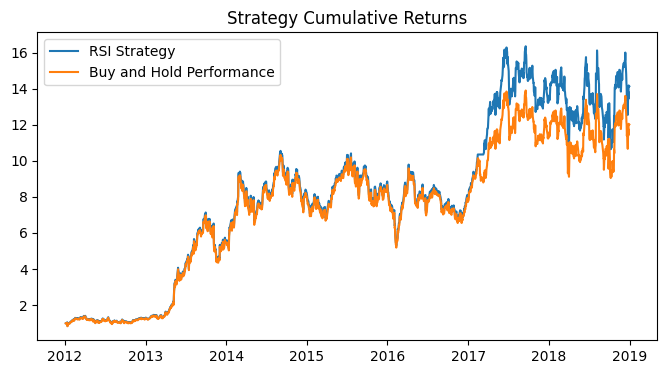

In [161]:
rsi_strategy(df_tsla_rsi, rsi_buy=28, rsi_sell=92)
plt.figure(figsize=(8, 4))
plt.plot(df_tsla_rsi['cumulative_return'], label = 'RSI Strategy')
plt.plot(df_tsla_bh['cumulative_earnings'], label = 'Buy and Hold Performance')
plt.title('Strategy Cumulative Returns')
plt.legend()
plt.show()

In [162]:
df_tsla_rsi

Price,High,Low,Open,Volume,one_day_signal,close,log_returns,RSI,position,daily_return,strategy_return,cumulative_return
Ticker,TSLA,TSLA,TSLA,TSLA,,,,,,,,
Date,,,,,,,,,,,,
2012-01-04,1.911333,1.833333,1.880667,9451500,-1.0,1.847333,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,1.862000,1.790000,1.850667,15082500,-1.0,1.808000,-0.021522,0.000000,1.0,-0.021292,NaN,NaN
2012-01-06,1.852667,1.760667,1.813333,14794500,-1.0,1.794000,-0.007773,0.000000,1.0,-0.007743,-0.007743,0.992257
2012-01-09,1.832667,1.741333,1.800000,13455000,1.0,1.816667,0.012556,35.227920,1.0,0.012635,0.012635,1.004794
2012-01-10,1.850667,1.816667,1.829333,10077000,1.0,1.841333,0.013486,55.091918,1.0,0.013578,0.013578,1.018436
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,20.966667,19.680000,20.900000,83398500,-1.0,19.692667,-0.079305,19.536464,1.0,-0.076242,-0.076242,12.541690
2018-12-26,21.798000,19.606001,20.000000,122446500,1.0,21.739332,0.098877,44.401984,1.0,0.103930,0.103930,13.845152


In [164]:
sharpe(df_tsla_rsi)

1.0086363204154132

# Now, to compensate for overfitting, I will test this strategy on Tesla stock after this, specifically from 2019:

In [170]:
df_tsla_rsi_test = yf.download('TSLA', start_test, end_test)

[*********************100%***********************]  1 of 1 completed


In [171]:
df_tsla_rsi_test['close'] = df_tsla_rsi_test['Close'].copy()

In [172]:
df_tsla_rsi_test.head()

Price,Close,High,Low,Open,Volume,close
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,
Date,,,,,,
2019-01-02,20.674667,21.008667,19.920000,20.406668,174879000,20.674667
2019-01-03,20.024000,20.626667,19.825333,20.466667,104478000,20.024000
2019-01-04,21.179333,21.200001,20.181999,20.400000,110911500,21.179333
2019-01-07,22.330667,22.449333,21.183332,21.448000,113268000,22.330667
2019-01-08,22.356667,22.934000,21.801332,22.797333,105127500,22.356667


In [173]:
get_rsi(df_tsla_rsi_test)

Price,Close,High,Low,Open,Volume,close,RSI
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,,
Date,,,,,,,
2019-01-02,20.674667,21.008667,19.920000,20.406668,174879000,20.674667,NaN
2019-01-03,20.024000,20.626667,19.825333,20.466667,104478000,20.024000,0.000000
2019-01-04,21.179333,21.200001,20.181999,20.400000,110911500,21.179333,67.200030
2019-01-07,22.330667,22.449333,21.183332,21.448000,113268000,22.330667,81.497188
2019-01-08,22.356667,22.934000,21.801332,22.797333,105127500,22.356667,81.704972
...,...,...,...,...,...,...,...
2019-12-24,28.350000,28.364668,27.512667,27.890667,120820500,28.350000,91.879043
2019-12-26,28.729334,28.898666,28.423332,28.527332,159508500,28.729334,92.704115


In [174]:
rsi_strategy(df_tsla_rsi_test, rsi_buy=28, rsi_sell=92)

Price,Close,High,Low,Open,Volume,close,RSI,position,daily_return,strategy_return,cumulative_return
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,,,,,,
Date,,,,,,,,,,,
2019-01-02,20.674667,21.008667,19.920000,20.406668,174879000,20.674667,NaN,NaN,NaN,NaN,NaN
2019-01-03,20.024000,20.626667,19.825333,20.466667,104478000,20.024000,0.000000,1.0,-0.031472,NaN,NaN
2019-01-04,21.179333,21.200001,20.181999,20.400000,110911500,21.179333,67.200030,1.0,0.057697,0.057697,1.057697
2019-01-07,22.330667,22.449333,21.183332,21.448000,113268000,22.330667,81.497188,1.0,0.054361,0.054361,1.115195
2019-01-08,22.356667,22.934000,21.801332,22.797333,105127500,22.356667,81.704972,1.0,0.001164,0.001164,1.116494
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,28.350000,28.364668,27.512667,27.890667,120820500,28.350000,91.879043,1.0,0.014384,0.014384,1.415801
2019-12-26,28.729334,28.898666,28.423332,28.527332,159508500,28.729334,92.704115,0.0,0.013380,0.013380,1.434745


In [175]:
df_tsla_bh_test = yf.download('TSLA', start_test, end_test)

df_tsla_bh_test['close'] = df_tsla_bh_test['Close'].copy()

df_tsla_bh_test['position'] = 1

df_tsla_bh_test['returns'] = df_tsla_bh_test['close'].pct_change()
df_tsla_bh_test = df_tsla_bh_test.dropna().copy()
df_tsla_bh_test['strategy_return'] = df_tsla_bh_test['position'] * df_tsla_bh_test['returns']
df_tsla_bh_test['cumulative_earnings'] = (1+df_tsla_bh_test['strategy_return']).cumprod()

[*********************100%***********************]  1 of 1 completed


In [176]:
df_tsla_bh_test

Price,Close,High,Low,Open,Volume,close,position,returns,strategy_return,cumulative_earnings
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,,,,,
Date,,,,,,,,,,
2019-01-03,20.024000,20.626667,19.825333,20.466667,104478000,20.024000,1,-0.031472,-0.031472,0.968528
2019-01-04,21.179333,21.200001,20.181999,20.400000,110911500,21.179333,1,0.057697,0.057697,1.024410
2019-01-07,22.330667,22.449333,21.183332,21.448000,113268000,22.330667,1,0.054361,0.054361,1.080098
2019-01-08,22.356667,22.934000,21.801332,22.797333,105127500,22.356667,1,0.001164,0.001164,1.081356
2019-01-09,22.568666,22.900000,22.098000,22.366667,81493500,22.568666,1,0.009483,0.009483,1.091610
...,...,...,...,...,...,...,...,...,...,...
2019-12-24,28.350000,28.364668,27.512667,27.890667,120820500,28.350000,1,0.014384,0.014384,1.371243
2019-12-26,28.729334,28.898666,28.423332,28.527332,159508500,28.729334,1,0.013380,0.013380,1.389591


In [177]:
sharpe(df_tsla_bh_test)

0.8590907009489002

In [178]:
sharpe(df_tsla_rsi_test)

0.9905805157503743

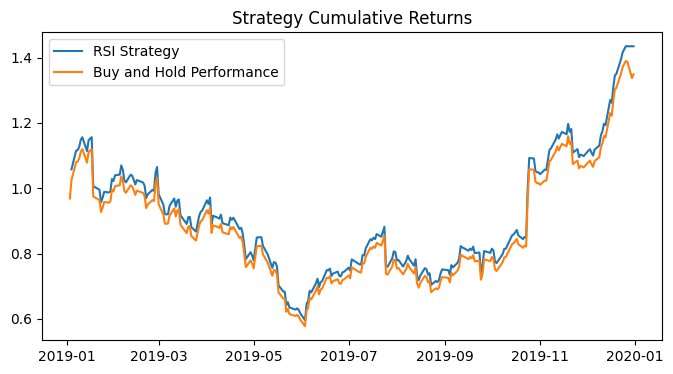

In [179]:
plt.figure(figsize=(8, 4))
plt.plot(df_tsla_rsi_test['cumulative_return'], label = 'RSI Strategy')
plt.plot(df_tsla_bh_test['cumulative_earnings'], label = 'Buy and Hold Performance')
plt.title('Strategy Cumulative Returns')
plt.legend()
plt.show()